In [33]:
!pip3 install mcerp sympy arrow
import numpy as np
import scipy
import mcerp
import matplotlib.pyplot as plt
import json
import os
import sys
import arrow

# Make sure that files from seduce_ml are available in this notebook
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# Predict temperature using machine learning technics

The objective is to predict future values of some variables from present and past values of some other variables.
The future values represents servers temperatures, and the present values are temperatures and/or consumptions of servers.

We define these variables:
* $Conso_{i, t}$ = Average power consumption of server i at time step t
* $Temp_{i, t}$ = Average temperature at the back of server i at time step t

And we define these sets
* $Consos_{t} = \bigcup_{i=1}^{48} Conso_{i, t}$
* $Temps_{t} = \bigcup_{i=1}^{48} Temp_{i, t}$
* $Inputs_{t} \subset (Consos_{t} \cup Consos_{t-1} \cup Temp_{t-1})$
* $Output_{t} \subset (Temp_{t})$

The work consists in finding a $predict$ function that achieves the following:

$ predict(Inputs) = ApproximatedOutputs$

where

$ AppoximatedOutputs \approx Outputs $

## k-NN regression

The idea behind a k-NN regression is to find training values close to the value that is being predicted, in order to compute an accurate approximation. A $distance$ function is given : it associates a score to each training value and the bigger is the score, the further is the training value to the value being predicted.

A k-NN regressor takes a parameter $k$ which corresponds to the number of close values that will be used to perform the prediction.

We define the following:
* $k$ = number of closest neighbours considered
* $closests(I)_k = A \subset training\_data, |A| = k$ and $\forall (x,y) \in A \times (B \setminus A), distance(x, I) < distance(y, I)$
* $closests(I)_k = (closest(I)_{k,1}, \dots, closest(I)_{k,k})$ where $distance(I, closest(I)_{k,n-1}) <= distance(I, closest(I)_{k,n}) <= distance(I, closest(I)_{k,n+1})$

The regression corresponds to the following:

$knn\_regression(I) = \begin{pmatrix}
1 / k \\
\dots\\
1 / k
\end{pmatrix} \times \sum\limits_{i=1}^k closests(I)_k $


## Neural network regression

$a_{i,j} = activation(\sum\limits_{k} w^{i}_{j,k} \times a^{i-1}_{k} + b^{i}_{j})$


### Gradient algorithm


Minimum at 2.2499994531145475


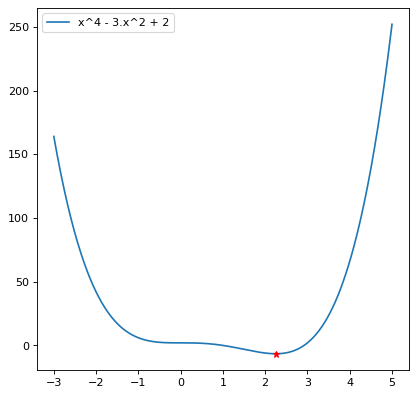

In [34]:
start_x = 1  # We start the search at x=6
gamma = 0.001  # Step size multiplier
precision = 0.00001  # Desired precision of result
max_iters = 10000  # Maximum number of iterations

# Derivative function
def f(x):
    return x**4 - 3*(x**3) + 2

def df(func, x):
    #return 4 * x**3 - 9 * x**2
    h = 0.0000001
    return (func(x+h) - func(x)) / h

minx = start_x

for _i in range(max_iters):
    if abs(df(f, minx)) <= precision:
        break
    minx = minx - df(f, minx) * gamma

print("Minimum at {}".format(minx))

fig, ax = plt.subplots(figsize=(6, 6), dpi= 80)


x = np.linspace(-3, 5, 500)
y = f(x)

# Using set_dashes() to modify dashing of an existing line
line1, = ax.plot(x, y, label='x^4 - 3.x^2 + 2')
ax.plot(minx, f(minx), 'r*')

ax.legend()
plt.show()


# I- Predict temperature using past temperature and consumption (ecotype-40)

## A- Neural network (60m time interval)

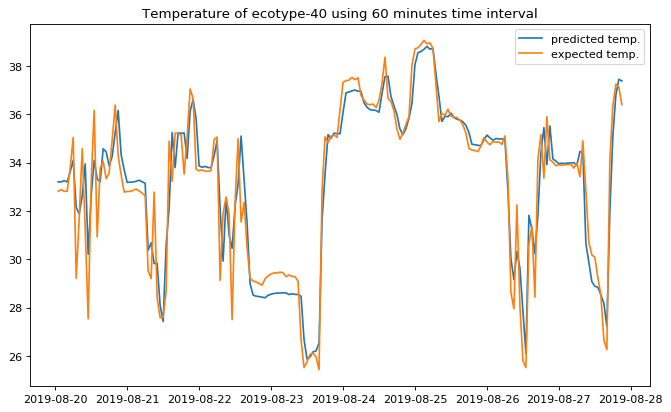

In [39]:
from keras.models import load_model
from sklearn.externals import joblib
from lib.data.seduce_data_loader import generate_real_consumption_data    


import warnings
from arrow.factory import ArrowParseWarning

warnings.simplefilter("ignore", ArrowParseWarning)

ORACLE_PATH = "../data/seduceml_2019_09_02_T_14_57_47.h5"
SCALER_PATH = "../data/scaler_92a82199-5278-428a-95e9-515d504ebda8"

oracle = load_model(ORACLE_PATH)
scaler = joblib.load(SCALER_PATH)

server_id = "ecotype-40"

additional_variables = [
    {
        "name": "ecotype_40_past_temp",
        "server_temperature": "ecotype-40",
        "shift": True
    },
]

x_valid, y_valid, tss_valid, data_valid, scaler, shape, servers_names_raw = \
            generate_real_consumption_data(validation_start_date,
                                           validation_end_date,
                                           data_file_path=f"../data/data_validation_60m.json",
                                           group_by=60,
                                           scaler=scaler,
                                           use_scaler=True,
                                           additional_variables=additional_variables)

server_idx = servers_names_raw.index(server_id)
date_format = "YYYY-MM-DDTHH:mm:ss"

x_dt = [arrow.get(tss, date_format).datetime
        for tss in tss_valid]

#print(x_tss[0])

predicted_values = []
expected_values = []
for idx, e in enumerate(y_valid):
    test_input = np.array([x_valid[idx]])
    expected_value = y_valid[idx]

    result = oracle.predict(test_input)

    unscaled_expected_values = scaler.inverse_transform(np.array([np.append(np.copy(test_input), expected_value)]))
    unscaled_predicted_values = scaler.inverse_transform(np.array([np.append(np.copy(test_input), result)]))

    expected_temp = unscaled_expected_values[:, -len(expected_value):][0]
    predicted_temp = unscaled_predicted_values[:, -len(expected_value):][0]
        
    predicted_values += [predicted_temp]
    expected_values += [expected_temp]
    
    server_power_consumption = unscaled_predicted_values[0][server_idx]
    
fig, ax = plt.subplots(figsize=(10, 6), dpi= 80)

# Using set_dashes() to modify dashing of an existing line
line1, = ax.plot(x_dt, predicted_values, label='predicted temp.')
line1, = ax.plot(x_dt, expected_values, label='expected temp.')

ax.legend()
ax.xaxis_date()

plt.title(f"Temperature of {server_id} using 60 minutes time interval")
plt.show()

# II- Predict temperature using consumption (ecotype-40)

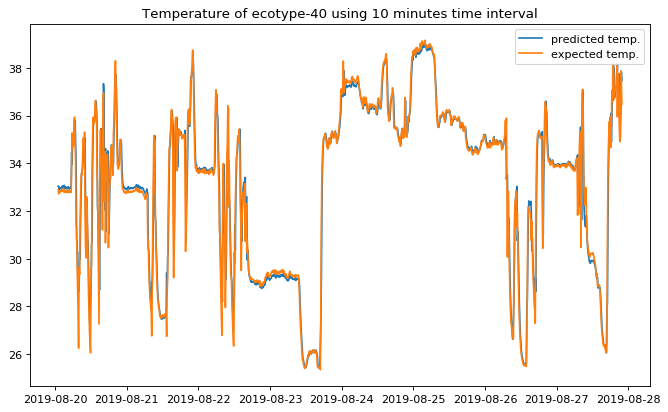

In [40]:
from keras.models import load_model
from sklearn.externals import joblib
from lib.data.seduce_data_loader import generate_real_consumption_data    


import warnings
from arrow.factory import ArrowParseWarning

warnings.simplefilter("ignore", ArrowParseWarning)

ORACLE_PATH = "../data/seduceml_2019_09_02_T_15_52_05.h5"
SCALER_PATH = "../data/scaler_2ce90f84-b292-4ef0-8bc6-b2d2896f5052"

validation_start_date = "2019-08-20T01:00:00.000Z"  
validation_end_date = "2019-08-27T22:00:00.000Z"    
        
oracle = load_model(ORACLE_PATH)
scaler = joblib.load(SCALER_PATH)

server_id = "ecotype-40"

additional_variables = [
    {
        "name": "ecotype_40_past_temp",
        "server_temperature": "ecotype-40",
        "shift": True
    },
]

x_valid, y_valid, tss_valid, data_valid, scaler, shape, servers_names_raw = \
            generate_real_consumption_data(validation_start_date,
                                           validation_end_date,
                                           data_file_path=f"../data/data_validation_10m.json",
                                           group_by=10,
                                           scaler=scaler,
                                           use_scaler=True,
                                           additional_variables=additional_variables)

server_idx = servers_names_raw.index(server_id)
date_format = "YYYY-MM-DDTHH:mm:ss"

x_dt = [arrow.get(tss, date_format).datetime
        for tss in tss_valid]

#print(x_tss[0])

predicted_values = []
expected_values = []
for idx, e in enumerate(y_valid):
    test_input = np.array([x_valid[idx]])
    expected_value = y_valid[idx]

    result = oracle.predict(test_input)

    unscaled_expected_values = scaler.inverse_transform(np.array([np.append(np.copy(test_input), expected_value)]))
    unscaled_predicted_values = scaler.inverse_transform(np.array([np.append(np.copy(test_input), result)]))

    expected_temp = unscaled_expected_values[:, -len(expected_value):][0]
    predicted_temp = unscaled_predicted_values[:, -len(expected_value):][0]
        
    predicted_values += [predicted_temp]
    expected_values += [expected_temp]
    
    server_power_consumption = unscaled_predicted_values[0][server_idx]
    
fig, ax = plt.subplots(figsize=(10, 6), dpi= 80)

# Using set_dashes() to modify dashing of an existing line
line1, = ax.plot(x_dt, predicted_values, label='predicted temp.')
line1, = ax.plot(x_dt, expected_values, label='expected temp.')

ax.legend()
ax.xaxis_date()

plt.title(f"Temperature of {server_id} using 10 minutes time interval")
plt.show()

In [ ]:
from keras.models import load_model
from sklearn.externals import joblib
from lib.data.seduce_data_loader import generate_real_consumption_data    


import warnings
from arrow.factory import ArrowParseWarning

warnings.simplefilter("ignore", ArrowParseWarning)

ORACLE_PATH = "../data/seduceml_2019_09_02_T_15_52_05.h5"
SCALER_PATH = "../data/scaler_2ce90f84-b292-4ef0-8bc6-b2d2896f5052"

validation_start_date = "2019-08-20T01:00:00.000Z"  
validation_end_date = "2019-08-27T22:00:00.000Z"    
        
oracle = load_model(ORACLE_PATH)
scaler = joblib.load(SCALER_PATH)

server_id = "ecotype-40"

additional_variables = [
    {
        "name": "ecotype_40_past_temp",
        "server_temperature": "ecotype-40",
        "shift": True
    },
]

x_valid, y_valid, tss_valid, data_valid, scaler, shape, servers_names_raw = \
            generate_real_consumption_data(validation_start_date,
                                           validation_end_date,
                                           data_file_path=f"../data/data_validation_10m.json",
                                           group_by=10,
                                           scaler=scaler,
                                           use_scaler=True,
                                           additional_variables=additional_variables)

server_idx = servers_names_raw.index(server_id)
date_format = "YYYY-MM-DDTHH:mm:ss"

x_dt = [arrow.get(tss, date_format).datetime
        for tss in tss_valid]

MAX_PREDICTION_STEP = 5

predicted_values = []
expected_values = []
for idx, e in enumerate(y_valid):
    test_input = np.array([x_valid[idx]])
    expected_value = y_valid[idx]

    result = oracle.predict(test_input)

    unscaled_expected_values = scaler.inverse_transform(np.array([np.append(np.copy(test_input), expected_value)]))
    unscaled_predicted_values = scaler.inverse_transform(np.array([np.append(np.copy(test_input), result)]))

    expected_temp = unscaled_expected_values[:, -len(expected_value):][0]
    predicted_temp = unscaled_predicted_values[:, -len(expected_value):][0]
        
    predicted_values += [predicted_temp]
    expected_values += [expected_temp]
    
    server_power_consumption = unscaled_predicted_values[0][server_idx]
    
fig, ax = plt.subplots(figsize=(10, 6), dpi= 80)

# Using set_dashes() to modify dashing of an existing line
line1, = ax.plot(x_dt, predicted_values, label='predicted temp.')
line1, = ax.plot(x_dt, expected_values, label='expected temp.')

ax.legend()
ax.xaxis_date()

plt.title(f"Temperature of {server_id} using 10 minutes time interval")
plt.show()